In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
df_train = pd.read_csv(r"Sentiment Analysis-Train.csv")
df_test = pd.read_csv(r"Sentiment Analysis-Test.csv")

# Text Cleaning & Preprocessing

### Implemented in Preprocessing.py

- seperate numbers from words
- turn numbers into 1-DIG, 2-DIG, 3-DIG, 4-DIG, MORE-DIG
- remove punctuation
- remove usernames
- remove urls
- remove hashtags

Got ideas from: 
- https://arxiv.org/ftp/arxiv/papers/1702/1702.03197.pdf
- https://ac.els-cdn.com/S1877050917321750/1-s2.0-S1877050917321750-main.pdf?_tid=34f291fc-dd9c-11e7-938d-00000aab0f6b&acdnat=1512905043_770e08134d89a36b483dbfbacac3280f


In [7]:
from Preprocessing import clean_text

df_train = clean_text(df_train)
df_test = clean_text(df_test)

# Word vectors -- Countvectorizer / Tfidf

Turn the clean text into word vectors (I found that tfidf worked better). 

Other params to play with - MIN_DF and ngram_range (I took bigrams)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

WORD_REPRESENTATION = 'tfidf' # flag to determine if we want word counts or tfidf

MIN_DF = 0.001 # threshold for cutting unfrequent terms (terms that appear in less than MIN_DF of tweets)

def word_vectors(df_train, df_test):
    y = np.array(df_train['Class'].tolist())
    count_vect = CountVectorizer(ngram_range=(1,2), min_df = MIN_DF)
    train_transcripts = df_train['clean_text'].values
    X_counts = count_vect.fit_transform(train_transcripts)
    test_transcripts = df_test['clean_text'].values
    X_test_counts = count_vect.transform(test_transcripts)
    if WORD_REPRESENTATION == 'counts':
        return count_vect, X_counts, X_test_counts, y
        
    else: # we want tfidf
        tf_transformer = TfidfTransformer(use_idf=False).fit(X_counts)
        X_tfidf = tf_transformer.transform(X_counts)
        X_test_tfidf = tf_transformer.transform(X_test_counts)
        return count_vect, X_tfidf, X_test_tfidf, y
    
    
count_vect, X, X_test, y = word_vectors(df_train, df_test)

NUM_WORDS = X.get_shape()[1]

### Just examining the data and term frequencies... no use for this block in the end

In [9]:
freqs = [(word, X.getcol(idx).sum()) for word, idx in count_vect.vocabulary_.items()]
#sort from largest to smallest
sorted_ = sorted (freqs, key = lambda x: -x[1])
print(len(sorted_))
print(len([x for x in sorted_ if int(x[1])>1]))
print(sorted_[0])

2510
316
(u'\u0627\u0644\u0644\u0647', 116.87475830753655)


In [23]:
print "y=" + str(len(y))
print "xtrain=" + str(X.shape[0])
print "xtest=" + str(X_test.shape[0])

y=1566
xtrain=1566
xtest=386


# Feature Engineering

Implemented in featureEngineering.py

- contains punctuations
- length of tweet
- recurring letters
- recurring puncts
- contains DIG
- containg emoji
- contains hashtag
- containg user
- contains url

In [24]:
from featureEngineering import add_features

train_features = add_features(df_train)
test_features = add_features(df_test)

# Scale tweet_length

In [25]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(train_features['tweet_length'].reshape(-1, 1))
train_features['tweet_length'] = scaler.transform(train_features['tweet_length'].reshape(-1, 1))
test_features['tweet_length'] = scaler.transform(test_features['tweet_length'].reshape(-1, 1))

/Applications/anaconda/envs/datas/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda/envs/datas/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/Applications/anaconda/envs/datas/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


# Merge word representation with the other features

In [26]:
feature_columns = ['w_'+x for x in count_vect.get_feature_names()]

train_word_counts = pd.DataFrame(X.todense(), columns=feature_columns)
train_org_df = pd.merge(train_features, train_word_counts, right_index=True, left_index=True)
redundant_columns = ['Text', 'Class', 'Index', 'clean_text']
df = train_org_df.drop(redundant_columns, axis=1)


test_word_counts = pd.DataFrame(X_test.todense(), columns=feature_columns)
test_org_df = pd.merge(test_features, test_word_counts, right_index=True, left_index=True)
test_redundant_columns = ['Text', 'Index', 'clean_text']
test_df = test_org_df.drop(test_redundant_columns, axis=1)

test_df

,?,!,.,tweet_length,contains_recurring_letters,contains_DIG,contains_hashtag,contains_user,contains_url,contains_emoji,...,w_يوجد,w_يوجد كفائات,w_يوسف,w_يوفر,w_يوفر لك,w_يوفق,w_يوكل,w_يوم,w_يوم من,w_ﻣﻦ
0,0.0,0.0,0.0,0.034722,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.006944,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.048611,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.0,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.0,0.069444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


# Use RandomForest for feature selection --> Didn't use this in the end

Train the best possible RandomForest on train and look at the most important features
Clean the dataset from noisy features and try again

In [27]:
from RandomForest import RandomForest

RF = RandomForest()
RF_best_params = RF.optimize_hyperparameters(df,y)
RF.fit(df, y, RF_best_params)
train_preds = RF.predict(df)

I STARTED GRID SEARCH...
I FINISHED GRID SEARCH!
Best parameters set found on development set:
{'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100, 'max_depth': 10}


In [28]:
import matplotlib.pyplot as plt

# We will only keep features with relative importance over this threshold
THRESH = 0.0001

features = df.columns.values
NUM_TOP_FEATURES = 100
importances = RF._model.feature_importances_
indices = np.argsort(abs(importances))[-NUM_TOP_FEATURES:]

plt.title('Feature Importances')
plt.barh(range(len(indices)), [importances[x] for x in indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

indices = np.argsort(np.abs(importances))
feat_sorted = [(features[x], importances[x]) for x in indices[::-1]]
print(len(feat_sorted))
new_columns = [x for x in feat_sorted if x[1]>=0.0001]
columns_to_drop = [x[0] for x in feat_sorted if x[1]<0.0001]
print(len(new_columns))

<Figure size 640x480 with 1 Axes>

2520
498


1: أنا متأكده أنو هذولي مدفوعلهم علشان يجون يغنون لأنو مافي ناس مهابيل لهالدرجه


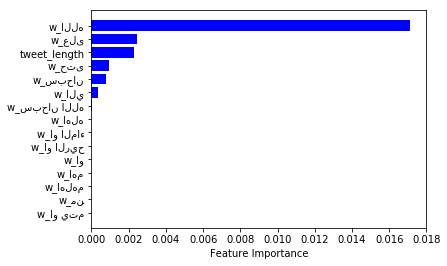

In [31]:
def plot_significant_features(model, X, transcript, NUM_TOP_FEATURES = 10, value_mod_func=None):
    features = X.index.values
    importances = model._model.feature_importances_
    importances = importances * X.values
    
    indices = np.argsort(np.abs(importances))[-NUM_TOP_FEATURES:]

    print("{}: {}".format(int(model.predict([X])), transcript))

    h = importances[indices]
    if value_mod_func is not None:
        array_value_mod_func = np.vectorize(value_mod_func)
        h = array_value_mod_func(h)
    plt.barh(range(len(indices)), h, color='b', align='center')
    plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
    plt.xlabel('Feature Importance')
    plt.show()
    
    return [{
        'index': x,
        'value': X.values[x],
        'feature': features[x],
        'importance': importances[x],
        # 'modified_importance': value_mod_func([importances[x]])
    } for x in indices[::-1]]

i=4; plot_significant_features(RF, df.iloc[i], test_org_df.iloc[i]['Text'], 15);

In [32]:
#cleaner_df = df.drop(columns_to_drop, axis=1)
cleaner_df = df

# Cross Validation to choose best model

Since there is little data, I prefer to choose a model on cross validation split, then optimize hyperparameters and train.

I experimented with:
- SVM
- Logistic Regression
- Naive Bayes
- Kernel SVM
- RandomForest

Each classifier implemented in its own .py file , inheriting from classifier.py (mostly for my convinience...).

I found that SVM performs best, with scores of:

Train mean: 0.968977 and std: 0.001392

Dev mean: 0.845603 and std: 0.045575

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from LinearSVM import LinearSVM
from LogReg import LogReg
from NaiveBayes import NaiveBayes
from RandomForest import RandomForest

# Linear SVM
print("LinSVM")
LinSVM = LinearSVM()
LinSVM_scores = LinSVM.cross_validation(cleaner_df, y)
#print("LinSVM mean: %f and std: %f"%(LinSVM_scores[0],LinSVM_scores[1]))


# logistic Regression
# print("LogReg")
# LogReg = LogReg()
# LogReg_scores = LogReg.cross_validation(cleaner_df, y)
#print("LogReg mean: %f and std: %f"%(LogReg_scores[0],LogReg_scores[1]))


# # Naive Bayes
# NB = NaiveBayes()
# NB_scores = NB.cross_validation(df, y)
# print("Naive Bayes mean: %f and std: %f"%(NB_scores[0],NB_scores[1]))


# # RandomForest
# RandFor = RandomForest()
# RF_scores = RandFor.cross_validation(cleaner_df, y)
# #print("Random Forest mean: %f and std: %f"%(RF_scores[0],RF_scores[1]))

LinSVM
Train mean: 0.968561 and std: 0.001341
Dev mean: 0.847574 and std: 0.045600


### Checking feature importance on LinSVM

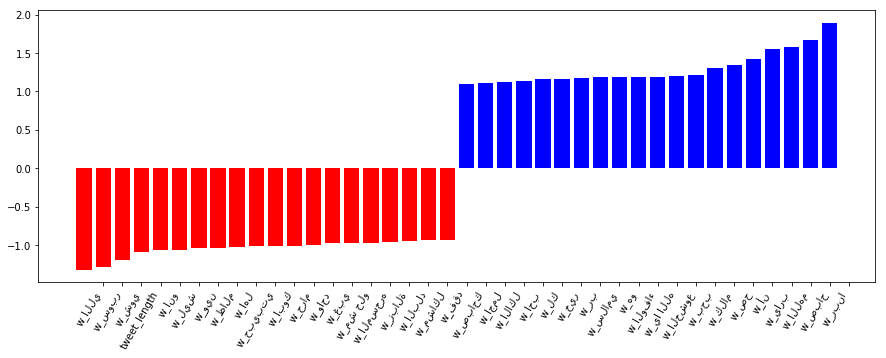

In [34]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()
 return feature_names[top_positive_coefficients], feature_names[top_negative_coefficients]

top_positive , top_negative = plot_coefficients(LinSVM._model, df.columns)

positive = [x.replace('w_','') for x in top_positive]
negative = [x.replace('w_','') for x in top_negative]

### Using Google translate I found that among terms that most point to a positive sentiment are:
- 'Fulfillment'
- 'I love'
- 'Good'
- 'resolution'

along with a lot of references to god:
- 'my Lord'
- 'Allah'
- 'O Lord'
- 'O Allah'
- 'Our Lord'

### Among the terms that most point to a negative sentiment are:
- 'unjust'
- 'Stupid'
- 'Why'
- 'Haram'
- 'Problems'
- 'Nuclear'
- 'Lost'
- 'Junk'
- 'Damned'
- ... also, it seems that longer tweets tend to be negative.

### While it's still google translate so it not foolproof, we do see that some context is captured.

# Now that we've chosen a Linear Model... (LinSVM)

## Let's perform Hyper Parameter Optimization and Training

In [35]:
from LinearSVM import LinearSVM
LinSVM = LinearSVM()
LinSVM_best_params = LinSVM.optimize_hyperparameters(df,y)
LinSVM.fit(df, y, LinSVM_best_params)

I STARTED GRID SEARCH...
I FINISHED GRID SEARCH!
Best parameters set found on development set:
()
{'C': 1}
I've returned your trained model :)


In [36]:
test_preds = LinSVM.predict(test_df)
test_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0,

# ~ ~ ~ 
# Now let's see how an LSTM performs

I implement the Keras classifier slightly different (i.e, explicitly) unlike the other classifiers, since they are all Sklearn where Keras requires a wrapper that I don't like that much. Note that this model is based on binary occurences of unigrams (unlike the linear models, with bigram tfidf).

For this reason (+ runtime efficiency) I use the keras tokenizer instead of the Vectorizers from before, and also implement CV.

In [37]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

#NUM_WORDS = 2000 #hyper parameter to play with, take NUM_WORDS top-frequent word

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(df_train['clean_text'].values)
X = tokenizer.texts_to_sequences(df_train['clean_text'].values)
X = pad_sequences(X)
y = np.array(df_train['Class'].tolist())

X_test = tokenizer.texts_to_sequences(df_test['clean_text'].values)
X_test = pad_sequences(X_test)

Using TensorFlow backend.


## Keras LSTM

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.metrics import f1_score
from keras.datasets import imdb
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold


class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_predict = val_predict.transpose()[0]
        val_targ = np.array(self.validation_data[1].ravel())
        res = precision_recall_fscore_support(val_targ, val_predict, average='weighted')
        print("******")
        print("f1: " + str(res[2]))
        print("******")
        return 

    
params = {'batch_size': 32,
         'num_splits': 20,
         'embedding_size': 64,
          'hidden_size': 64,
          'dropout':0.2 ,
          'recurrent_dropout': 0.2, 
          'epochs': 10,
          'num_words': NUM_WORDS
         }


def lstm_cross_validation(X, y, params):

    skf = StratifiedKFold(n_splits=params['num_splits'], shuffle=True)
    train_res = []
    dev_res = []
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print('Build model...')
        model = Sequential()
        model.add(Embedding(NUM_WORDS, params['embedding_size']))
        model.add(LSTM(params['hidden_size'], dropout=params['dropout'], recurrent_dropout=params['recurrent_dropout']))
        model.add(Dense(1, activation='sigmoid'))


        # try using different optimizers and different optimizer configs
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        print("Training on fold " + str(index+1) + "/"+ str(params['num_splits'])+"...")
        # Generate batches from indices
        X_train, X_dev = X[train_indices], X[val_indices]
        y_train, y_dev = y[train_indices], y[val_indices]

        model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                  callbacks=[Metrics()], validation_data = (X_dev, y_dev))

        train_preds = model.predict_classes(X_train)
        dev_preds = model.predict_classes(X_dev)
        train_res.append(f1_score(y_train, train_preds))
        dev_res.append(f1_score(y_dev, dev_preds))
        
    print("Train LSTM mean: %f and std: %f"%(np.mean(train_res), np.std(train_res)))
    print("Dev LSTM mean: %f and std: %f"%(np.mean(dev_res), np.std(dev_res)))
    
lstm_cross_validation(X, y, params)


Build model...
Training on fold 1/20...
Train on 1487 samples, validate on 79 samples
Epoch 1/10
1487/1487 [==============================] - 18s 12ms/step - loss: 0.6867 - acc: 0.5481 - val_loss: 0.6604 - val_acc: 0.7342
******
f1: 0.718703880686
******
Epoch 2/10
1487/1487 [==============================] - 17s 11ms/step - loss: 0.5487 - acc: 0.7882 - val_loss: 0.4618 - val_acc: 0.8354
******
f1: 0.834010954824
******
Epoch 3/10
1487/1487 [==============================] - 17s 12ms/step - loss: 0.3026 - acc: 0.8931 - val_loss: 0.3417 - val_acc: 0.8354
******
f1: 0.834702862081
******
Epoch 4/10
1487/1487 [==============================] - 20s 13ms/step - loss: 0.1845 - acc: 0.9395 - val_loss: 0.2988 - val_acc: 0.8861
******
f1: 0.886112481049
******
Epoch 5/10
1487/1487 [==============================] - 19s 13ms/step - loss: 0.1335 - acc: 0.9570 - val_loss: 0.3108 - val_acc: 0.8608
******
f1: 0.860536244502
******
Epoch 6/10
1487/1487 [==============================] - 17s 11ms/step

### The LSTM gets the following results:

Train LSTM mean: 0.976330 and std: 0.002420

Dev LSTM mean: 0.860143 and std: 0.042228

I present the train mean to asses overfitting.

In [14]:
model = Sequential()
model.add(Embedding(NUM_WORDS, params['embedding_size']))
model.add(LSTM(params['hidden_size'], dropout=params['dropout'], recurrent_dropout=params['recurrent_dropout']))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, batch_size=params['batch_size'], epochs=params['epochs'])

Epoch 1/10
1566/1566 [==============================] - 6s - loss: 0.6828 - acc: 0.5409     
Epoch 2/10
1566/1566 [==============================] - 4s - loss: 0.5164 - acc: 0.7976     
Epoch 3/10
1566/1566 [==============================] - 4s - loss: 0.2987 - acc: 0.9010     
Epoch 4/10
1566/1566 [==============================] - 4s - loss: 0.1874 - acc: 0.9374     
Epoch 5/10
1566/1566 [==============================] - 4s - loss: 0.1389 - acc: 0.9464     
Epoch 6/10
1566/1566 [==============================] - 4s - loss: 0.1107 - acc: 0.9572     
Epoch 7/10
1566/1566 [==============================] - 4s - loss: 0.0899 - acc: 0.9642     
Epoch 8/10
1566/1566 [==============================] - 4s - loss: 0.0760 - acc: 0.9732     
Epoch 9/10
1566/1566 [==============================] - 4s - loss: 0.0731 - acc: 0.9674     
Epoch 10/10
1566/1566 [==============================] - 4s - loss: 0.0616 - acc: 0.9732     


In [16]:
keras_test_preds = model.predict_classes(X_test)
keras_test_preds = keras_test_preds.ravel()
keras_test_preds

352/386 [==========================>...] - ETA: 0s

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1,